In [1]:
from scipy.io import netcdf
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
import calculations as calc
import similarity_measures

In [2]:
nc = netcdf.netcdf_file("data/era-int_1979-2019-mm-l70-u.nc")

In [3]:
u = nc.variables["u"]

my_qbo = calc.derive(u[:,:,:,:], lon = 148, lat = 126, level = 0, lon_step = 0, lat_step = 0)
my_deseasonalized_qbo = calc.deseasonalize_monthly_time_series(my_qbo)

In [4]:
sim = calc.calculate_series_similarity_per_period(u[:, :, :, :], my_deseasonalized_qbo, level=0, period_length=12, sim_func=similarity_measures.correlation_similarity)

C:\Users\tousp\anaconda3\envs\climate_similarity_measures\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


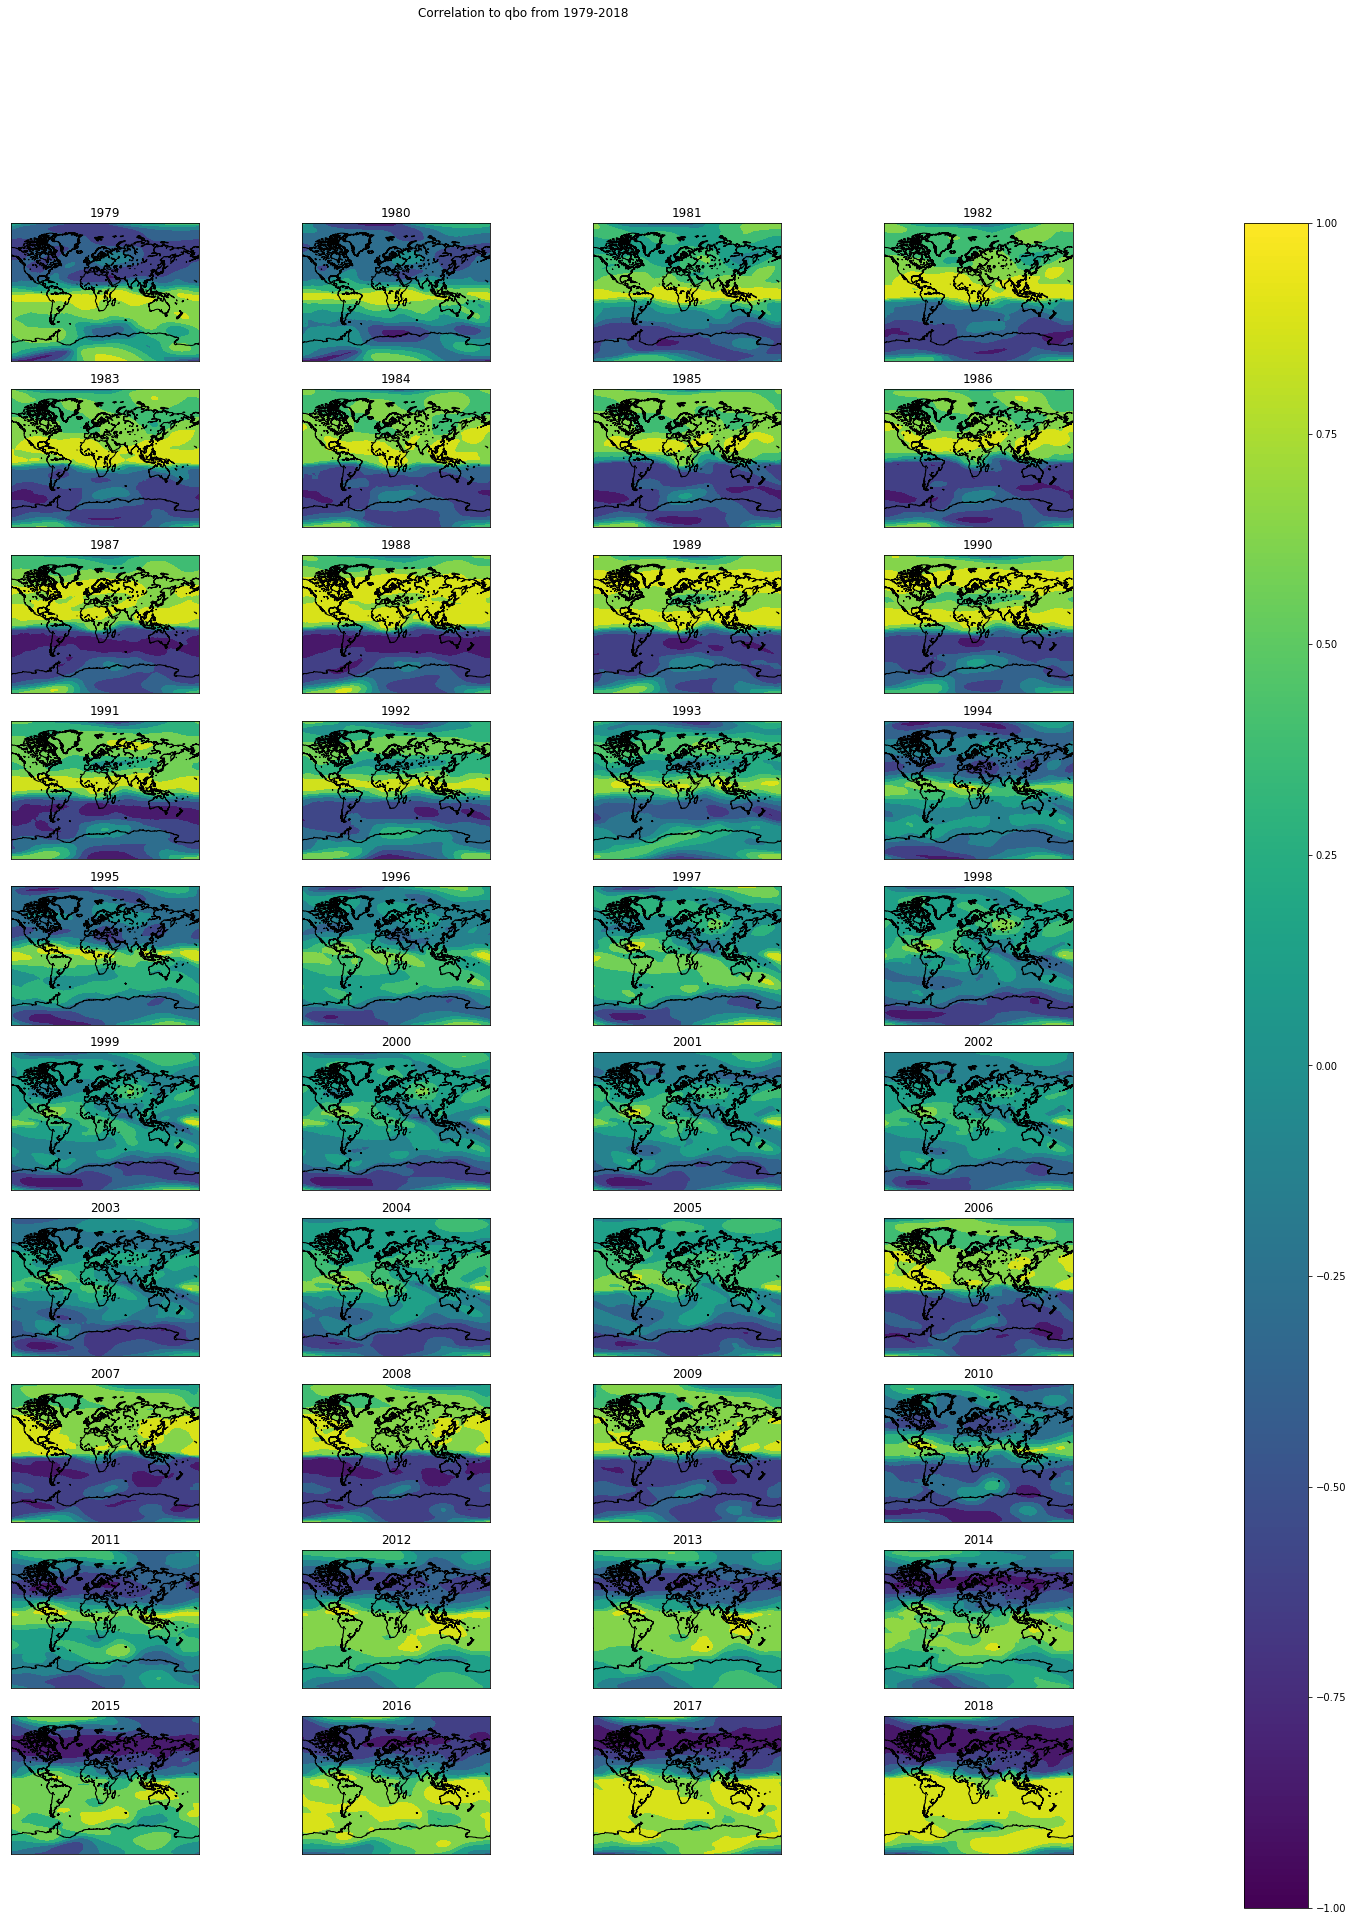

In [5]:
#Plot similarity on maps
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
mapper= matplotlib.cm.ScalarMappable(norm=norm)

fig, axes =plt.subplots(figsize = (20,30), nrows=10, ncols=4)

for i, ax in enumerate(axes.flat):
    m = Basemap(projection='mill',lon_0=30,resolution='l', ax=ax)
    m.drawcoastlines()

    lons, lats = m.makegrid(512, 256)
    x, y = m(lons, lats)

    cs = m.contourf(x, y, sim[i])
    ax.set_title(str(1979 + i))
    
fig.suptitle("Correlation to qbo from 1979-2018")
plt.colorbar(mapper, cax=plt.axes([1, 0.1, 0.045, 0.78]))
plt.show()